# Imports

In [2]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:
player_id_columns = ['VisStPchID', 'HmStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID',
                     'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmBat1ID',
                     'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
visiting_id_columns = ['VisStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']
home_id_columns = ['HmStPchID','HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']


def check_missing_players(player_list, player_data):
    missing_players = []
    for game in player_list:
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
    return missing_players


def lahman_id_dictionary(file_path):
    people_df = pd.read_csv(file_path, header=0)
    people_df['Player'] = people_df['nameFirst'] + ' ' + people_df['nameLast']
    id_to_name = people_df.set_index('playerID')['Player'].to_dict()
    return id_to_name


def retro_id_dictionary(file_path):
    people_df = pd.read_csv(file_path, header=0)
    people_df['Player'] = people_df['nameFirst'] + ' ' + people_df['nameLast']
    id_to_name = people_df.set_index('retroID')['Player'].to_dict()
    return id_to_name


#only works with per game daata
def map_player_ids_to_names_per_game(df, player_id_columns=player_id_columns, file_path='./Lahman_MLB_People/Lahman_MLB_People.csv'):
    id_to_name=retro_id_dictionary(file_path)
    for column in player_id_columns:
        df[column] = df[column].map(id_to_name)
    return df


def map_player_ids_to_names(df, file_path='./Lahman_MLB_People/Lahman_MLB_People.csv'):
    id_to_name=lahman_id_dictionary(file_path)
    player_id_columns = ['playerID']
    for column in player_id_columns:
        df[column] = df[column].map(id_to_name)
        # print("initial player conversion", df['playerID'])
    return df


def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(df, id_to_name, visiting_id_columns=visiting_id_columns, home_id_columns=home_id_columns):
    all_data = []
    df_copy = df.copy()  # Create a copy of the DataFrame
    # Map player IDs to names using vectorized operation
    df_copy[visiting_id_columns] = df_copy[visiting_id_columns].applymap(id_to_name.get)
    df_copy[home_id_columns] = df_copy[home_id_columns].applymap(id_to_name.get)
    visiting_scores = df_copy['VisRuns'].tolist()
    home_scores = df_copy['HmRuns'].tolist()
    all_data = list(zip(df_copy[visiting_id_columns].values.tolist(), df_copy[home_id_columns].values.tolist(), visiting_scores, home_scores))
    return all_data

# def get_player_data(paths):
#     le = LabelEncoder()
#     player_dfs = []
#     for path in paths:
#         df = pd.read_csv(path)
#         df['Team'] = le.fit_transform(df['Team'])     
#         if 'Pos' in df.columns:
#             df['Pos'] = le.fit_transform(df['Pos'])
#         if 'batting' in path:
#             df['ExtraCol1'] = 0
#             df['ExtraCol2'] = 0
#             df['ExtraCol3'] = 0
#             df['ExtraCol4'] = 0
#             df['ExtraCol5'] = 0
#             df['ExtraCol6'] = 0
#             df['ExtraCol7'] = 0
#             df['ExtraCol8'] = 0
#         df.columns = ['Player'] + list(range(len(df.columns) - 1))
#         df['Player'] = df['Player'].str.lower()
#         player_dfs.append(df)
#     combined_player = pd.concat(player_dfs)
#     combined_player = combined_player.groupby('Player', as_index=False).mean()
#     final_player = combined_player.set_index('Player').T.to_dict('list')
#     return final_player

def get_player_data(df):
    le = LabelEncoder()
    df['teamID'] = le.fit_transform(df['teamID'])     
    if 'Pos' in df.columns:
        df['Pos'] = le.fit_transform(df['Pos'])
    if 'batting' in df.columns:
        df['ExtraCol1'] = 0
        df['ExtraCol2'] = 0
        df['ExtraCol3'] = 0
        df['ExtraCol4'] = 0
        df['ExtraCol5'] = 0
        df['ExtraCol6'] = 0
        df['ExtraCol7'] = 0
        df['ExtraCol8'] = 0
    df = map_player_ids_to_names(df)
    df = df.drop(['Unnamed: 0','lgID', 'stint'], axis=1)
    df.rename(columns={'playerID':'Player'},inplace=True)
    df = df.drop(['yearID'], axis=1)
    df.columns = ['Player'] + list(range(len(df.columns) - 1))
    # df['Player'].isna().sum()
    df['Player'] = df['Player'].astype(str).str.lower()
    df.fillna(0, inplace=True)
    print(df['Player'].head())
    # print("full df to see what is text", df.head(1))
    combined_player = df.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0 # might need to flip
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def simulate_betting_season(bets, df, wallet_balance=1000.0):
    wallet_balance_history = [wallet_balance]  # Start with the initial wallet balance
    for bet in bets:
        bet_amount, bet_team, bet_date = bet
        row = df[(df['Date'] == bet_date) & ((df['HmTm'] == bet_team) | (df['VisTm'] == bet_team))]
        if not row.empty and not row.isnull().values.any():
            if row['winner'].values[0]==1:
                winner = row['HmTm'].values[0]
                if winner == bet_team:
                    if row['home_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['home_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['home_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            else:
                winner = row['VisTm'].values[0]
                if winner == bet_team:
                    if row['visiting_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['visiting_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['visiting_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            wallet_balance_history.append(wallet_balance)
        else:
            print(f"No betting data for date: {bet_date}")
    return wallet_balance, wallet_balance_history


def get_player_vector(players, player_data):
    return [player_data[player.lower()] for player in players]


# def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
#     results, bets, skipped = [], [], []
#     for i in range(len(player_list)):
#         try:
#             visiting_players = player_list.iloc[i][0][0]
#             home_players = player_list.iloc[i][0][1]
#             visiting_vector = get_player_vector(visiting_players, player_data)
#             home_vector = get_player_vector(home_players, player_data)
#             game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
#             game_vector = torch.tensor([game_vector], dtype=torch.float)
#             model.eval()
#             with torch.no_grad():
#                 logits = model(game_vector)
#                 probs = logits.softmax(dim=-1)
#                 _, pred = torch.max(logits, 1)
#                 pred = pred.item()
#                 prob = probs[0][pred].item()
#             results.append(pred)
#             bets.append(base_bet * prob * scaler if augment else base_bet)
#         except:
#             skipped.append(i)
#     return results, bets, skipped

def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(player_list)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    for i in range(num_games):
        try:
            visiting_players = player_list.iloc[i][0][0]
            print(visiting_players)
            home_players = player_list.iloc[i][0][1]
            print(home_players)
            visiting_vector = get_player_vector(visiting_players, player_data)
            home_vector = get_player_vector(home_players, player_data)
            game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
            game_vector = torch.tensor([game_vector], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = pred
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped


def generate_bets(results, bets, df, skipped):
    final_bets = []
    for i, (result, (_, row)) in enumerate(zip(results, df.iterrows())):
        if i in skipped:
            continue
        if result == 1:
            bet_team = row['HmTm']
        else:
            bet_team = row['VisTm']
        bet_date = row['Date']
        final_bets.append((bets[i], bet_team, bet_date))
    return final_bets

In [4]:
# import pandas as pd
# import os
# import glob

# path = 'C:/Users/vile3/.cursor-tutor/projects/python/Lahman_compiled_player_data/'
# all_files = glob.glob(os.path.join(path, "*.csv"))
# people_path = 'C:/Users/vile3/.cursor-tutor/projects/python/Lahman_MLB_People/Lahman_MLB_People.csv'
# people_df = pd.read_csv(people_path)

# for file in all_files:
#     df = pd.read_csv(file)
#     df = df[df['yearID'] >= 2000]
#     df = pd.merge(df, people_df[['playerID', 'nameFirst', 'nameLast']], on='playerID', how='left')
#     df['Player'] = df['nameFirst'] + ' ' + df['nameLast']
#     df.drop(['playerID', 'nameFirst', 'nameLast', 'Unnamed: 0','stint','lgID' ], axis=1, inplace=True)  # Remove 'Unnamed' column
#     df.rename(columns={'teamID': 'Team'}, inplace=True)  # Rename 'teamID' to 'Team'
#     cols = df.columns.tolist()
#     cols = cols[-1:] + cols[:-1]  # Make 'Player' the first column
#     df = df[cols]
#     split_files = df.groupby('yearID')
#     df.drop(['yearID'], axis=1, inplace=True)
#     for name, group in split_files:
#         group.to_csv(f"{path}{os.path.splitext(os.path.basename(file))[0]}_{name}.csv", index=False)



# Data

In [5]:
def load_data(game_path, player_path, betting_paths, id_to_name_path, train_years, test_year):
    # Dictionary 
    lahman_id_to_name = lahman_id_dictionary(id_to_name_path)   
    retro_id_to_name  = retro_id_dictionary(id_to_name_path) 
        # Import all csv files
    all_game_csvs = [path.replace('\\', '/') for path in glob(game_path + '*.csv')]
    
    # Concatenate all dataframes
    all_data = pd.concat([pd.read_csv(f) for f in all_game_csvs])
    
    # Convert 'Date' column to datetime
    all_data['Date'] = pd.to_datetime(all_data['Date'], format='%Y%m%d')
    
    # Filter dataframes based on 'Date' column
    game_csvs_train = all_data[all_data['Date'].dt.year.isin(train_years)]
    game_csvs_test = all_data[all_data['Date'].dt.year == test_year]
    
    all_player_csvs = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
        # Concatenate all dataframes
    all_player_data = pd.concat([pd.read_csv(f) for f in all_player_csvs])
    
    # Convert 'Date' column to datetime
    all_player_data['yearID'] = pd.to_datetime(all_player_data['yearID'], format='%Y')
    
    # Filter dataframes based on 'Date' column
    player_csvs_train = all_player_data[all_player_data['yearID'].dt.year.isin(train_years)]
    player_csvs_test = all_player_data[all_player_data['yearID'].dt.year == test_year]

    xlsx_dataframes = []
    for i, path in enumerate(betting_paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)
    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects') 

    # print("betting data", xlsx_dataframes)
    # print("per game train data", game_csvs_train)
    print("per player train data", player_csvs_train.head(1))
    # print("per game test data", game_csvs_test)
    # print("per player test data", player_csvs_test)

    train_game_data = [game for game in get_game_data(game_csvs_train,retro_id_to_name)]
    test_game_data = [game for game in get_game_data(game_csvs_test,retro_id_to_name)]

    # print("endoftraingame", train_game_data)
    train_player_data = get_player_data(player_csvs_train)
    test_player_data = get_player_data(player_csvs_test)
   
    X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
    X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

    return X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data, xlsx_dataframes, retro_id_to_name, lahman_id_to_name


id_to_name_path = './Lahman_MLB_People/Lahman_MLB_People.csv'
# load data
game_path = './Lahman_MLB_per_game_data/'
player_path = './Lahman_compiled_player_data/'

test_year = 2021
train_years = range(2010, test_year) #train years from 2010 to test year -1 for some reason range reduces the year by 1.

xlsx_path = './betting_odds/'
# glfields_path = './alldata/gamelogs/glfields.txt'
betting_paths = [path for path in glob(xlsx_path + '*.xlsx')]

X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data, xlsx_dataframes, retro_id_to_name, lahman_id_to_name = load_data(game_path, player_path, betting_paths, id_to_name_path, train_years, test_year)


# player_paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
# for path in player_paths:
#     df = pd.read_csv(path)
#     view_data(df)


# schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]

print("xlsx_dataframes", xlsx_dataframes)

per player train data       Name  Age  #days  Lev   Tm     G  PA   AB    R    H  ...  Str  StL  StS  \
92866  NaN  NaN    NaN  NaN  NaN  53.0 NaN  0.0  0.0  0.0  ...  NaN  NaN  NaN   

       GB/FB  LD  PU  WHIP  BAbip  SO9  SO/W  
92866    NaN NaN NaN   NaN    NaN  NaN   NaN  

[1 rows x 80 columns]
92866    nan
92867    nan
92868    nan
92869    nan
92870    nan
Name: Player, dtype: object


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
date1, date2 = int(str(test_year)+'0101'), int(str(test_year+1)+'0101') 
for i in range(len(xlsx_dataframes)):
    xlsx_dataframes = xlsx_dataframes[(xlsx_dataframes['Date'].astype(int) >= date1) & (xlsx_dataframes['Date'].astype(int) <= date2)]
#

#     
# print(xlsx_dataframes)
# try:
#     xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
# except pd.errors.InvalidIndexError:
#     print('Error: Reindexing only valid with uniquely valued Index objects')
# print(xlsx_dataframes)


# with open(glfields_path, 'r') as file:
#     glfields_data = file.read()

# xlsx_dataframes = xlsx_dataframes[['Date', 'HmTm', 'VisTm', 'home_open', 'visiting_open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.rename(columns={'Team': 'HmTm', 'Open': 'home_open'}, inplace=True)
visiting_teams_df.rename(columns={'Team': 'VisTm', 'Open': 'visiting_open'}, inplace=True)

# Merge on 'date'
xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
xlsx_dataframes = xlsx_dataframes[['Date', 'HmTm', 'VisTm','home_open','visiting_open']]

# Assuming df is your DataFrame and 'HmTm' and 'VisTm' are the columns with team abbreviations
abbreviation_mapping = {
    "CUB": "CHN",  # Chicago Cubs
    "SDG": "SDN",  # San Diego Padres
    "LAD": "LAN",  # Los Angeles Dodgers
    "SFO": "SFN",  # San Francisco Giants
    "KAN": "KCA",  # Kansas City Royals
    "CWS": "CHA",  # Chicago White Sox
    "NYY": "NYA",  # New York Yankees
    "TAM": "TBA",  # Tampa Bay Rays
    "LAA": "ANA"   # Los Angeles Angels
}

xlsx_dataframes['HmTm'] = xlsx_dataframes['HmTm'].map(abbreviation_mapping).fillna(xlsx_dataframes['HmTm'])
xlsx_dataframes['VisTm'] = xlsx_dataframes['VisTm'].map(abbreviation_mapping).fillna(xlsx_dataframes['VisTm'])

print("Correctly mapped team names",xlsx_dataframes)
# Define the new path

path_csv = './Lahman_MLB_per_game_data/Lahman_MLB_per_game_data.csv'




# Read the CSV file

df = pd.read_csv(path_csv, header=0)
df = df[(df['Date'] >= date1) & (df['Date'] <= date2)]
print(df)
# Replace the txt_dataframes with the new dataframe
txt_dataframes = [df]

# The rest of your code remains the same
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["HmRuns"] > row["VisRuns"] else 2 if row["HmRuns"] == row["VisRuns"] else 0, axis=1)

# # Adjust the column names to match the new CSV file
# txt_dataframes_concat = txt_dataframes_concat[['Date', 'HmTm', 'VisTm', 'HmStPchNm', 'VisStPchNm', 
#                                               'HmBat1Nm', 'HmBat2Nm', 'HmBat3Nm', 
#                                               'HmBat4Nm', 'HmBat5Nm', 'HmBat6Nm', 
#                                               'HmBat7Nm', 'HmBat8Nm', 'HmBat9Nm', 
#                                               'VisBat1Nm', 'VisBat2Nm', 'VisBat3Nm', 
#                                               'VisBat4Nm', 'VisBat5Nm', 'VisBat6Nm', 
#                                               'VisBat7Nm', 'VisBat8Nm', 'VisBat9Nm',
#                                               'winner']]

# Adjust the column names to match the new CSV file
txt_dataframes_concat = txt_dataframes_concat[['Date', 'HmTm', 'VisTm', 'HmStPchID', 'VisStPchID', 
                                              'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 
                                              'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 
                                              'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 
                                              'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 
                                              'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 
                                              'VisBat7ID', 'VisBat8ID', 'VisBat9ID',
                                              'winner']]


xlsx_dataframes['Date'] = xlsx_dataframes['Date'].astype(int)
# Now perform the merge operation

merged_dataframes=[]
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['Date', 'HmTm', 'VisTm'])
merged_dataframes_full = pd.merge(txt_dataframes_concat, xlsx_dataframes, on=['Date', 'HmTm', 'VisTm'], how="left")

player_list_concat=[]
player_list_concat = pd.concat(txt_dataframes)




# player_list_concat = player_list_concat[['Date', 'HmTm', 'VisTm', 'HmStPchNm', 'VisStPchNm', 
#                                           'HmBat1Nm', 'HmBat2Nm', 'HmBat3Nm', 
#                                           'HmBat4Nm', 'HmBat5Nm', 'HmBat6Nm', 
#                                           'HmBat7Nm', 'HmBat8Nm', 'HmBat9Nm', 
#                                           'VisBat1Nm', 'VisBat2Nm', 'VisBat3Nm', 
#                                           'VisBat4Nm', 'VisBat5Nm', 'VisBat6Nm', 
#                                           'VisBat7Nm', 'VisBat8Nm', 'VisBat9Nm',
#                                           'HmRuns', 'VisRuns',
#                                           'HmBat1Pos', 'HmBat2Pos', 
#                                           'HmBat3Pos', 'HmBat4Pos', 
#                                           'HmBat5Pos', 'HmBat6Pos', 
#                                           'HmBat7Pos', 'HmBat8Pos', 
#                                           'HmBat9Pos', 'VisBat1Pos', 
#                                           'VisBat2Pos', 'VisBat3Pos', 
#                                           'VisBat4Pos', 'VisBat5Pos', 
#                                           'VisBat6Pos', 'VisBat7Pos', 
#                                           'VisBat8Pos', 'VisBat9Pos']]

player_list_concat = player_list_concat[['Date', 'HmTm', 'VisTm', 'HmStPchID', 'VisStPchID', 
                                          'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 
                                          'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 
                                          'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 
                                          'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 
                                          'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 
                                          'VisBat7ID', 'VisBat8ID', 'VisBat9ID',
                                          'HmRuns', 'VisRuns',
                                          'HmBat1Pos', 'HmBat2Pos', 
                                          'HmBat3Pos', 'HmBat4Pos', 
                                          'HmBat5Pos', 'HmBat6Pos', 
                                          'HmBat7Pos', 'HmBat8Pos', 
                                          'HmBat9Pos', 'VisBat1Pos', 
                                          'VisBat2Pos', 'VisBat3Pos', 
                                          'VisBat4Pos', 'VisBat5Pos', 
                                          'VisBat6Pos', 'VisBat7Pos', 
                                          'VisBat8Pos', 'VisBat9Pos']]

# Replace player IDs with names in merged_player_dataframe

print(player_list_concat)
# Replace player IDs with names in player_list_concat
player_list_concat = map_player_ids_to_names_per_game(player_list_concat)

player_list_concat.rename(columns={'VisStPchID': 'VisStPchNm', 'HmStPchID': 'HmStPchNm', 
                                   'VisBat1ID': 'VisBat1Nm', 'VisBat2ID': 'VisBat2Nm', 
                                   'VisBat3ID': 'VisBat3Nm', 'VisBat4ID': 'VisBat4Nm', 
                                   'VisBat5ID': 'VisBat5Nm', 'VisBat6ID': 'VisBat6Nm', 
                                   'VisBat7ID': 'VisBat7Nm', 'VisBat8ID': 'VisBat8Nm', 
                                   'VisBat9ID': 'VisBat9Nm', 'HmBat1ID': 'HmBat1Nm', 
                                   'HmBat2ID': 'HmBat2Nm', 'HmBat3ID': 'HmBat3Nm', 
                                   'HmBat4ID': 'HmBat4Nm', 'HmBat5ID': 'HmBat5Nm', 
                                   'HmBat6ID': 'HmBat6Nm', 'HmBat7ID': 'HmBat7Nm', 
                                   'HmBat8ID': 'HmBat8Nm', 'HmBat9ID': 'HmBat9Nm'}, inplace=True)

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['VisStPchNm'],) +
        tuple(row[f'VisBat{i}Nm'] for i in sorted(range(1, 10), key=lambda i: row[f'VisBat{i}Pos']))
    ),
    (
        (row['HmStPchNm'],) +
        tuple(row[f'HmBat{i}Nm'] for i in sorted(range(1, 10), key=lambda i: row[f'HmBat{i}Pos']))
    ),
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['Date', 'HmTm', 'VisTm'])
print(merged_player_dataframe)
# player_id_columns = ['VisStPchID', 'HmStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
# for column in player_id_columns:
#     merged_player_dataframe[column] = merged_player_dataframe[column].map(id_to_name)

# merged_player_dataframe.rename(columns={'VisStPchID': 'VisStPchNm', 'HmStPchID': 'HmStPchNm', 
#                                    'VisBat1ID': 'VisBat1Nm', 'VisBat2ID': 'VisBat2Nm', 
#                                    'VisBat3ID': 'VisBat3Nm', 'VisBat4ID': 'VisBat4Nm', 
#                                    'VisBat5ID': 'VisBat5Nm', 'VisBat6ID': 'VisBat6Nm', 
#                                    'VisBat7ID': 'VisBat7Nm', 'VisBat8ID': 'VisBat8Nm', 
#                                    'VisBat9ID': 'VisBat9Nm', 'HmBat1ID': 'HmBat1Nm', 
#                                    'HmBat2ID': 'HmBat2Nm', 'HmBat3ID': 'HmBat3Nm', 
#                                    'HmBat4ID': 'HmBat4Nm', 'HmBat5ID': 'HmBat5Nm', 
#                                    'HmBat6ID': 'HmBat6Nm', 'HmBat7ID': 'HmBat7Nm', 
#                                    'HmBat8ID': 'HmBat8Nm', 'HmBat9ID': 'HmBat9Nm'}, inplace=True)

Correctly mapped team names           Date HmTm VisTm home_open visiting_open
0     20210401  CHN   PIT      -205           183
1     20210401  PHI   ATL      -105          -105
2     20210401  SDN   ARI      -210           188
3     20210401  COL   LAN       188          -210
4     20210401  CIN   STL      -115           105
...        ...  ...   ...       ...           ...
2457  20211027  HOU   ATL      -115          -105
2458  20211029  ATL   HOU      -115          -105
2459  20211030  ATL   HOU      -115          -105
2460  20211031  ATL   HOU      -105          -115
2461  20211102  HOU   ATL      -120           100

[2462 rows x 5 columns]
       Unnamed: 0      Date  DblHdr  Day VisTm VisTmLg  VisTmGNum HmTm HmTmLg  \
49486       49487  20210401       0  Thu   PIT      NL          1  CHN     NL   
49487       49488  20210401       0  Thu   SLN      NL          1  CIN     NL   
49488       49489  20210401       0  Thu   LAN      NL          1  COL     NL   
49489       49490  2021

In [ ]:
print(merged_player_dataframe)

          Date HmTm VisTm home_open visiting_open       HmStPchNm  \
0     20210401  CHN   PIT      -205           183  Kyle Hendricks   
1     20210401  PHI   ATL      -105          -105      Aaron Nola   
2     20210401  SDN   ARI      -210           188      Yu Darvish   
3     20210401  COL   LAN       188          -210  German Marquez   
4     20210401  NYA   TOR      -165           149     Gerrit Cole   
...        ...  ...   ...       ...           ...             ...   
2187  20211003  SEA   ANA      -180           150  Tyler Anderson   
2188  20211003  CHA   DET      -310           250     Dylan Cease   
2189  20211003  KCA   MIN       100          -120   Jackson Kowar   
2190  20211003  HOU   OAK      -195           165    Jose Urquidy   
2191  20211003  WAS   BOS       180          -220       Joan Adon   

             VisStPchNm          HmBat1Nm           HmBat2Nm        HmBat3Nm  \
0             Chad Kuhl          Ian Happ  Willson Contreras   Anthony Rizzo   
1          

In [ ]:


# # load data
# game_path = './game_data/'
# player_path = './player_data/'

# game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' in path]

# player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' in path]

# train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
# test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

# train_player_data = get_player_data(player_csvs_train)
# test_player_data = get_player_data(player_csvs_test)

# X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
# X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

In [ ]:
print(merged_player_dataframe)

          Date HmTm VisTm home_open visiting_open       HmStPchNm  \
0     20210401  CHN   PIT      -205           183  Kyle Hendricks   
1     20210401  PHI   ATL      -105          -105      Aaron Nola   
2     20210401  SDN   ARI      -210           188      Yu Darvish   
3     20210401  COL   LAN       188          -210  German Marquez   
4     20210401  NYA   TOR      -165           149     Gerrit Cole   
...        ...  ...   ...       ...           ...             ...   
2187  20211003  SEA   ANA      -180           150  Tyler Anderson   
2188  20211003  CHA   DET      -310           250     Dylan Cease   
2189  20211003  KCA   MIN       100          -120   Jackson Kowar   
2190  20211003  HOU   OAK      -195           165    Jose Urquidy   
2191  20211003  WAS   BOS       180          -220       Joan Adon   

             VisStPchNm          HmBat1Nm           HmBat2Nm        HmBat3Nm  \
0             Chad Kuhl          Ian Happ  Willson Contreras   Anthony Rizzo   
1          

In [ ]:
# xlsx_dataframes.to_csv('output.csv', index=False)

In [ ]:
# print(merged_player_dataframe['lineup'])

# NN

In [ ]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
model

neural_net(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (input_layer): Linear(in_features=640, out_features=1280, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1280, out_features=1280, bias=True)
  )
  (output_layer): Linear(in_features=1280, out_features=2, bias=True)
)

In [ ]:
train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
patience = 5
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

for epoch in range(50):  # number of epochs
    model.train()
    train_losses = []
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            valid_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    print(f'Validation Loss: {avg_valid_loss}')

    # Save the model at each epoch
    epoch_model_path = f'model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), epoch_model_path)

    # Update the best model if validation loss improves
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Epoch 1:   1%|          | 2/394 [00:00<00:30, 12.65it/s]

Epoch 1: 100%|██████████| 394/394 [00:20<00:00, 19.25it/s]


Training Loss: 0.6850299508438498
Validation Loss: 0.675264614193063


Epoch 2: 100%|██████████| 394/394 [00:20<00:00, 19.33it/s]


Training Loss: 0.6829888416728392
Validation Loss: 0.6740625845758539


Epoch 3: 100%|██████████| 394/394 [00:20<00:00, 19.36it/s]


Training Loss: 0.6823969332094725
Validation Loss: 0.6766678424257981


Epoch 4: 100%|██████████| 394/394 [00:20<00:00, 19.25it/s]


Training Loss: 0.6814186424773356
Validation Loss: 0.6798427293175145


Epoch 5: 100%|██████████| 394/394 [00:20<00:00, 19.66it/s]


Training Loss: 0.6818533945204642
Validation Loss: 0.6784682054268686


Epoch 6: 100%|██████████| 394/394 [00:20<00:00, 19.58it/s]


Training Loss: 0.6809927146446887
Validation Loss: 0.6753891675095809


Epoch 7: 100%|██████████| 394/394 [00:20<00:00, 19.56it/s]


Training Loss: 0.6813596447712273
Validation Loss: 0.6716312922929463


Epoch 8: 100%|██████████| 394/394 [00:20<00:00, 19.60it/s]


Training Loss: 0.6806291474908741
Validation Loss: 0.6749229164499986


Epoch 9: 100%|██████████| 394/394 [00:20<00:00, 19.63it/s]


Training Loss: 0.6808279303427275
Validation Loss: 0.6774744109103554


Epoch 10: 100%|██████████| 394/394 [00:20<00:00, 19.44it/s]


Training Loss: 0.6801264275451602
Validation Loss: 0.6729383578425959


Epoch 11: 100%|██████████| 394/394 [00:20<00:00, 19.47it/s]


Training Loss: 0.6814440724813393
Validation Loss: 0.6741767996235898


Epoch 12: 100%|██████████| 394/394 [00:20<00:00, 19.60it/s]


Training Loss: 0.6799705854527236
Validation Loss: 0.6713004300468847


Epoch 13: 100%|██████████| 394/394 [00:20<00:00, 19.63it/s]


Training Loss: 0.6797780193350642
Validation Loss: 0.6772535443305969


Epoch 14: 100%|██████████| 394/394 [00:20<00:00, 19.55it/s]


Training Loss: 0.6796900215487794
Validation Loss: 0.6739001117254558


Epoch 15: 100%|██████████| 394/394 [00:20<00:00, 19.52it/s]


Training Loss: 0.678427213490917
Validation Loss: 0.6767041902793082


Epoch 16: 100%|██████████| 394/394 [00:20<00:00, 19.53it/s]


Training Loss: 0.6808604401380277
Validation Loss: 0.6684578421868776


Epoch 17: 100%|██████████| 394/394 [00:20<00:00, 19.53it/s]


Training Loss: 0.6782838057745532
Validation Loss: 0.6701970790561876


Epoch 18: 100%|██████████| 394/394 [00:20<00:00, 19.36it/s]


Training Loss: 0.6781932409039608
Validation Loss: 0.6688113855688196


Epoch 19: 100%|██████████| 394/394 [00:18<00:00, 20.83it/s]


Training Loss: 0.6784877609177894
Validation Loss: 0.671464320860411


Epoch 20: 100%|██████████| 394/394 [00:19<00:00, 19.84it/s]


Training Loss: 0.6774217725405233
Validation Loss: 0.6671560736078965


Epoch 21: 100%|██████████| 394/394 [00:20<00:00, 19.01it/s]


Training Loss: 0.6773333124400396
Validation Loss: 0.669069357608494


Epoch 22: 100%|██████████| 394/394 [00:20<00:00, 19.06it/s]


Training Loss: 0.6765655524234482
Validation Loss: 0.6735850776496687


Epoch 23: 100%|██████████| 394/394 [00:20<00:00, 18.97it/s]


Training Loss: 0.6753395650592552
Validation Loss: 0.6950788137159849


Epoch 24: 100%|██████████| 394/394 [00:20<00:00, 19.18it/s]


Training Loss: 0.6755992441915618
Validation Loss: 0.6730951870742597


Epoch 25: 100%|██████████| 394/394 [00:22<00:00, 17.88it/s]


Training Loss: 0.6752338497166707
Validation Loss: 0.6731447483363905
Early stopping triggered
Confusion Matrix:
[[ 405  715]
 [ 283 1026]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.45      1120
           1       0.59      0.78      0.67      1309

    accuracy                           0.59      2429
   macro avg       0.59      0.57      0.56      2429
weighted avg       0.59      0.59      0.57      2429



# Run Season

('chad kuhl', 'chad kuhl', 'jacob stallings', 'colin moran', 'adam frazier', "ke'bryan hayes", 'kevin newman', 'bryan reynolds', 'anthony alford', 'gregory polanco')
('kyle hendricks', 'kyle hendricks', 'willson contreras', 'anthony rizzo', 'david bote', 'kris bryant', 'javier baez', 'joc pederson', 'ian happ', 'jason heyward')
('max fried', 'max fried', "travis d'arnaud", 'freddie freeman', 'ozzie albies', 'austin riley', 'dansby swanson', 'marcell ozuna', 'cristian pache', 'ronald acuna')
('aaron nola', 'aaron nola', 'j. t. realmuto', 'rhys hoskins', 'jean segura', 'alec bohm', 'didi gregorius', 'andrew mccutchen', 'adam haseley', 'bryce harper')
('madison bumgarner', 'madison bumgarner', 'stephen vogt', 'christian walker', 'eduardo escobar', 'asdrubal cabrera', 'josh rojas', 'david peralta', 'ketel marte', 'pavin smith')
('yu darvish', 'yu darvish', 'victor caratini', 'eric hosmer', 'jake cronenworth', 'manny machado', 'fernando tatis', 'jurickson profar', 'tommy pham', 'wil myers')

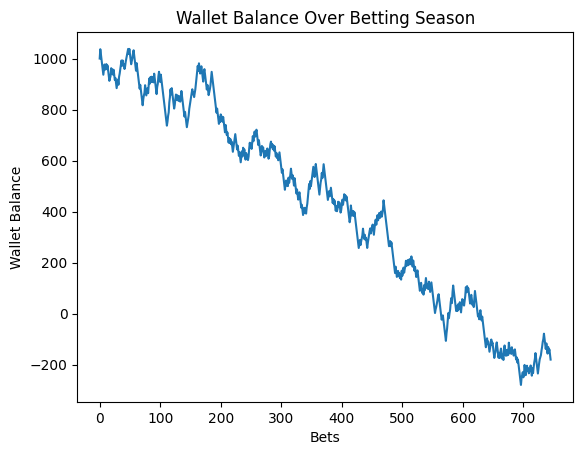

In [ ]:

subset_df = merged_player_dataframe[(merged_player_dataframe['Date'] >= date1) & (merged_player_dataframe['Date'] <= date2)]
player_list = subset_df['lineup'].to_frame()
player_list['lineup'] = player_list['lineup'].apply(lambda list_of_tuples: [tuple([player.lower() for player in team]) for team in list_of_tuples])
player_list= player_list.applymap(lambda x: x)
results, bets, skipped = predict_game_outcome(player_list, train_player_data, model, augment=False, scaler=10, base_bet=20)

final_bets = generate_bets(results, bets, subset_df, skipped)

print('Number of games: ', len(subset_df))
print('Predictions: ', results)
print('Bets: ', bets)

wallet_balance, wallet_balance_history = simulate_betting_season(final_bets, merged_dataframes)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

In [ ]:
len(subset_df)
len(results)

2192

2192

In [ ]:
print(subset_df)

          Date HmTm VisTm  home_open  visiting_open       HmStPchNm  \
0     20210401  CHN   PIT       -205            183  Kyle Hendricks   
1     20210401  PHI   ATL       -105           -105      Aaron Nola   
2     20210401  SDN   ARI       -210            188      Yu Darvish   
3     20210401  COL   LAN        188           -210  German Marquez   
4     20210401  NYA   TOR       -165            149     Gerrit Cole   
...        ...  ...   ...        ...            ...             ...   
2187  20211003  SEA   ANA       -180            150  Tyler Anderson   
2188  20211003  CHA   DET       -310            250     Dylan Cease   
2189  20211003  KCA   MIN        100           -120   Jackson Kowar   
2190  20211003  HOU   OAK       -195            165    Jose Urquidy   
2191  20211003  WAS   BOS        180           -220       Joan Adon   

             VisStPchNm          HmBat1Nm           HmBat2Nm        HmBat3Nm  \
0             Chad Kuhl          Ian Happ  Willson Contreras   Anth

In [ ]:
len(results)

2192

In [ ]:
len(merged_dataframes)

2192

In [ ]:
print(lahman_id_dictionary)
print(retro_id_dictionary)

<function lahman_id_dictionary at 0x00000163C5DAC310>
<function retro_id_dictionary at 0x00000163D9D6EC10>


In [ ]:
# def swap_keys_values(original_dict):
#     return {v: k for k, v in original_dict.items()}

# lahman_name_to_id = swap_keys_values(lahman_id_to_name)
# retro_name_to_id = swap_keys_values(retro_id_to_name)


In [ ]:
print(player_list.applymap(lambda x: x))

                                                 lineup
0     [(chad kuhl, chad kuhl, jacob stallings, colin...
1     [(max fried, max fried, travis d'arnaud, fredd...
2     [(madison bumgarner, madison bumgarner, stephe...
3     [(clayton kershaw, clayton kershaw, austin bar...
4     [(hyun jin ryu, danny jansen, vladimir guerrer...
...                                                 ...
2187  [(reid detmers, kurt suzuki, jared walsh, davi...
2188  [(tyler alexander, dustin garneau, harold cast...
2189  [(charlie barnes, ryan jeffers, miguel sano, j...
2190  [(cole irvin, yan gomes, seth brown, tony kemp...
2191  [(chris sale, chris sale, christian vazquez, k...

[2192 rows x 1 columns]


In [ ]:
print(final_bets)

[(20, 'PIT', 20210401), (20, 'ATL', 20210401), (20, 'ARI', 20210401), (20, 'LAN', 20210401), (20, 'NYA', 20210401), (20, 'CLE', 20210401), (20, 'ANA', 20210401), (20, 'HOU', 20210401), (20, 'MIN', 20210401), (20, 'TBA', 20210401), (20, 'LAN', 20210402), (20, 'ARI', 20210402), (20, 'TBA', 20210402), (20, 'BOS', 20210402), (20, 'PIT', 20210403), (20, 'ATL', 20210403), (20, 'LAN', 20210403), (20, 'NYA', 20210403), (20, 'DET', 20210403), (20, 'BOS', 20210403), (20, 'HOU', 20210403), (20, 'TBA', 20210403), (20, 'MIN', 20210403), (20, 'ATL', 20210404), (20, 'PIT', 20210404), (20, 'LAN', 20210404), (20, 'NYA', 20210404), (20, 'BOS', 20210404), (20, 'ANA', 20210404), (20, 'MIN', 20210404), (20, 'MIL', 20210405), (20, 'SFN', 20210405), (20, 'TOR', 20210405), (20, 'KCA', 20210405), (20, 'BOS', 20210405), (20, 'ANA', 20210405), (20, 'ATL', 20210406), (20, 'MIL', 20210406), (20, 'MIN', 20210406), (20, 'NYA', 20210406), (20, 'TOR', 20210406), (20, 'LAN', 20210406), (20, 'MIL', 20210407), (20, 'ATL'

In [ ]:
len(skipped)

1447

In [ ]:
# len(final_bets)
len(train_player_data)

3741

# Misc

In [ ]:
missing_players = check_missing_players(player_list, train_player_data)
print('Missing players:', missing_players)
len(missing_players)

Missing players: ['l', 'i', 'n', 'e', 'u', 'p']


6

In [ ]:
print(skipped)
# for index in skipped:missing_players_per_game = []


[6, 11, 14, 15, 17, 22, 26, 28, 31, 35, 37, 39, 40, 43, 46, 49, 52, 53, 55, 57, 58, 60, 62, 64, 66, 72, 74, 76, 78, 82, 84, 85, 91, 93, 94, 96, 100, 103, 104, 105, 106, 108, 116, 117, 118, 119, 120, 123, 124, 127, 128, 133, 136, 137, 138, 139, 140, 144, 147, 148, 151, 152, 153, 155, 157, 158, 159, 161, 163, 165, 167, 168, 169, 170, 171, 172, 177, 181, 182, 183, 188, 191, 193, 194, 198, 206, 208, 209, 211, 212, 214, 218, 219, 220, 221, 222, 223, 226, 231, 235, 236, 237, 240, 241, 242, 243, 245, 246, 247, 248, 249, 251, 253, 254, 255, 258, 260, 264, 266, 267, 268, 270, 271, 272, 273, 274, 277, 279, 280, 282, 284, 285, 290, 291, 292, 300, 301, 302, 306, 310, 312, 316, 317, 321, 323, 325, 328, 329, 336, 337, 339, 340, 341, 342, 345, 348, 350, 351, 352, 356, 361, 362, 367, 369, 371, 372, 374, 376, 377, 382, 383, 384, 385, 386, 388, 391, 392, 397, 400, 401, 403, 406, 408, 409, 412, 414, 418, 420, 422, 423, 427, 428, 432, 437, 438, 439, 444, 445, 450, 451, 452, 454, 456, 457, 459, 463, 465, 4

In [ ]:
print('Number of results: ', len(results))
print('Number of bets: ', len(bets))
print('Number of skipped games: ', len(skipped))
print('Number of final bets: ', len(final_bets))
print('Number of wallet balance history entries: ', len(wallet_balance_history))

Number of results:  2192
Number of bets:  2192
Number of skipped games:  1447
Number of final bets:  745
Number of wallet balance history entries:  746


In [ ]:
# extra_players_per_game = []
# for game in player_list_df.iloc[:, 0]:
#     # Flatten the list of players for the current game
#     game_players_flat = [player for sublist in game for player in sublist]
#     # Convert the list into a set to remove duplicates
#     game_player_set = set(game_players_flat)
#     extra_players = train_player_set - game_player_set
#     extra_players_per_game.append(extra_players)

# print(extra_players_per_game)

In [ ]:
train_player_names = list(train_player_data.keys())
# print(train_player_names)
test_player_names = list(test_player_data.keys())
print(test_player_names)
# print(test_player_data)
# print(player_list_concat)
# print(na_rows)
# List of columns that contain player names
# Concatenate all player names into one column
# List of columns that contain player names
player_columns = ['HmStPchNm', 'VisStPchNm', 'HmBat1Nm', 'HmBat2Nm', 'HmBat3Nm', 'HmBat4Nm', 'HmBat5Nm', 'HmBat6Nm', 'HmBat7Nm', 'HmBat8Nm', 'HmBat9Nm', 'VisBat1Nm', 'VisBat2Nm', 'VisBat3Nm', 'VisBat4Nm', 'VisBat5Nm', 'VisBat6Nm', 'VisBat7Nm', 'VisBat8Nm', 'VisBat9Nm']

# Stack all player names into one column
all_player_list = player_list_concat[player_columns].melt(value_name='players')['players']
print(all_player_list)

# Convert both lists to sets
all_players_set = set(all_player_list)
all_players_set = {player.lower() for player in all_players_set}
test_player_names_set = set(test_player_names)
train_player_names_set = set(train_player_names)

# Find the difference between the two sets
missing_test_players = all_players_set.difference(test_player_names_set)
missing_train_players = all_players_set.difference(train_player_names_set)



# Print the missing players
print(f"Missing players in the testing dataset: {missing_test_players}")
print(f"Missing players in the training dataset: {missing_train_players}")

len(missing_train_players)


['a. j. alexy', 'a. j. cole', 'a. j. minter', 'a. j. puk', 'aaron ashby', 'aaron bummer', 'aaron civale', 'aaron fletcher', 'aaron hicks', 'aaron judge', 'aaron loup', 'aaron nola', 'aaron northcraft', 'aaron sanchez', 'aaron slegers', 'abraham almonte', 'abraham toro', 'adalberto mondesi', 'adam cimber', 'adam conley', 'adam duvall', 'adam eaton', 'adam engel', 'adam frazier', 'adam haseley', 'adam kolarek', 'adam morgan', 'adam ottavino', 'adam plutko', 'adam wainwright', 'adbert alzolay', 'adolis garcia', 'adonis medina', 'adrian houser', 'adrian morejon', 'adrian sampson', 'adrian sanchez', 'aj pollock', 'aj ramos', 'akeem bostick', 'akil baddoo', 'alan trejo', 'albert abreu', 'albert almora', 'albert pujols', 'alberto baldonado', 'alcides escobar', 'alec bettinger', 'alec bohm', 'alec mills', 'aledmys diaz', 'alejandro kirk', 'alejo lopez', 'alek manoah', 'alex avila', 'alex blandino', 'alex bregman', 'alex claudio', 'alex cobb', 'alex colome', 'alex de goti', 'alex dickerson', 'a

168

In [ ]:
# train_dataset = vector_dataset(X_train_resampled, y_train_resampled)
# instantiate the random undersampler
#rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
#smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
#print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
#print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))